# Overview of Ontario's Covid-19 Spread
> Insights into the Covid-19 spread in Ontario, Canada.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/test.png

In [53]:
#hide

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
import altair as alt

from IPython.display import HTML, display
import pytz

import ipywidgets as widgets

from datetime import datetime, timedelta, timezone

print('Libraries successfully imported.')

Libraries successfully imported.


In [54]:
#hide
#%%time

url = 'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'
url_2 = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv'
url_3 = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/8a88fe6d-d8fb-41a3-9d04-f0550a44999f/download/daily_change_in_cases_by_phu.csv'

#geo = gpd.read_file('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/4f39b02b-47fe-4e66-95b6-e6da879c6910/download/conposcovidloc.geojson') 

src_conpos = pd.read_csv(url, index_col=0, parse_dates=['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date']).reset_index()
src_testing = pd.read_csv(url_2, index_col=0, parse_dates=['Reported Date']).reset_index()
src_daily = pd.read_csv(url_3, index_col=0, parse_dates=['Date']).reset_index()

# duplicate entry for December 5th, 2020 causing error
src_testing.drop_duplicates(inplace=True)

print('Source files successfully loaded.')

Source files successfully loaded.


In [55]:
#hide
last_date = src_testing['Reported Date'].max()
init_date = src_conpos['Accurate_Episode_Date'].min()
display(HTML("Ontario data set last updated on: " + last_date.strftime("%x")))

In [56]:
#hide_input
src_testing[src_testing['Confirmed Negative'] > 0].tail() # no confirmed negatives after March 29th 2020

testing_latest = src_testing[src_testing['Reported Date'] == src_testing['Reported Date'].max()]

# get the previous day results
testing_delta1 = src_testing[src_testing['Reported Date'] == src_testing['Reported Date'].max() - timedelta(days=1)]

# get the daily percentage +/-
dailypct = src_testing.join(src_testing[['Total Cases', 'Resolved', 'Confirmed Positive', 'Deaths']].pct_change().add_suffix('_pct'))

dailypct = dailypct[dailypct['Reported Date'] == dailypct['Reported Date'].max()]

# apply a percentage format; conventional formatting method throws an error
def percentage_delta(raw):
  # pctfmt = raw.map('{:+.2%}'.format)
  # split = str(pctfmt).split()
  formatted_pct = str(raw.map('{:+.2%}'.format)).split()[1]
  return formatted_pct

# original background colour code: #504e4e, secondary: #585858

display(HTML(
    
    "<div id='number-plate' style = 'background-color: #ececec; padding: 30px; text-align: center; marginTop: 1%; marginBottom: 1%;'>" +

    "<p style='color: black; font-size: 32px'> Ontario Covid-19 Cases to Date</p>"
    
    "<div id='confirmed' style = 'display: inline-block'> <span style='color: black; font-size: 23px;'> Confirmed: " +
    str('{:,.0f}'.format(int(testing_latest['Total Cases']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '> " + 
    str('{0:+,d}'.format(int(testing_latest['Total Cases']) - (int(testing_delta1['Total Cases'])))) +
    ' (' + percentage_delta(dailypct['Total Cases_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='resolved' style = 'display: inline-block'> <span style='color: #228b22; font-size: 23px; margin-left: 20px;'> Resolved: " + 
    str('{:,.0f}'.format(int(testing_latest['Resolved']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Resolved']) - (int(testing_delta1['Resolved'])))) +
    ' (' + percentage_delta(dailypct['Resolved_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='active' style = 'display: inline-block'> <span style='color: orange; font-size: 23px; margin-left: 20px;'> Active: " + 
    str('{:,.0f}'.format(int(testing_latest['Confirmed Positive']))) +"</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Confirmed Positive']) - (int(testing_delta1['Confirmed Positive'])))) +
    ' (' + percentage_delta(dailypct['Confirmed Positive_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='deaths' style = 'display: inline-block'> <span style='color: red; font-size: 23px; margin-left: 20px;'> Deaths: " + 
    str('{:,.0f}'.format(int(testing_latest['Deaths']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Deaths']) - (int(testing_delta1['Deaths'])))) +
    ' (' + percentage_delta(dailypct['Deaths_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<br><div id='rates' style = 'display: block; marginTop: 1%;'> " +

    "<div id='deathrate' style = 'display: inline-block'> <span style='color: black;'> Current Death Rate: " +
    "</span>" +
    "<span style = 'color: red'>" +
    str((testing_latest['Deaths'] / testing_latest['Total Cases']).map('{:.2%}'.format)).split()[1] + 
    "</span>" +
    "</div>" +

    "<div id='survivalrate' style = 'display:inline-block'> <span style='color: black; margin-left: 20px;'> Current Survival Rate: " + 
    "</span>" +
    "<span style = 'color: #228b22'>" +
    str(((testing_latest['Total Cases'] - testing_latest['Deaths']) / testing_latest['Total Cases']).map('{:.2%}'.format)).split()[1] + 
    "</span>" +
    "</div>" +

    "</div>" +

    "<span style='color: black; font-size: 11px;'> Ontario data last updated: " + 
    str(testing_latest['Reported Date'].max().strftime('%Y-%m-%d')) + ", Refreshed on: " + datetime.now(pytz.timezone('America/New_York') ).strftime("%Y-%m-%d at %H:%M") +
    "</span>" +

    "</div>"
    
    ))

In [57]:
#hide
src_conpos.head()

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-01-22,2020-01-23,NaT,2020-01-25,50s,FEMALE,TRAVEL,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
1,2,2020-01-21,2020-01-23,NaT,2020-01-23,50s,MALE,TRAVEL,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
2,3,2020-02-05,2020-02-21,NaT,2020-02-22,20s,FEMALE,TRAVEL,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
3,4,2020-02-16,2020-02-25,NaT,2020-02-25,60s,FEMALE,TRAVEL,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
4,5,2020-02-20,2020-02-26,NaT,2020-02-26,60s,MALE,TRAVEL,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


In [58]:
#hide
src_conpos['Case_AcquisitionInfo'].unique()
src_conpos['Outcome1'].unique()

array(['Resolved', 'Fatal', 'Not Resolved'], dtype=object)

In [59]:
#hide
src_conpos.groupby(["Accurate_Episode_Date","Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU", "Accurate_Episode_Date"]).tail()

,Accurate_Episode_Date,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases
6367,2020-12-15,York Region Public Health Services,Newmarket,44.048023,-79.480239,135
6396,2020-12-16,York Region Public Health Services,Newmarket,44.048023,-79.480239,190
6424,2020-12-17,York Region Public Health Services,Newmarket,44.048023,-79.480239,185
6442,2020-12-18,York Region Public Health Services,Newmarket,44.048023,-79.480239,11
6444,2020-12-19,York Region Public Health Services,Newmarket,44.048023,-79.480239,1


In [60]:
 #hide

# create dataframe of all active cases in Ontario by region since Covid-19 inception
# Note: Brampton and Caledon not included in PHU Cities; use Region instead

active = src_conpos[src_conpos['Outcome1'] == "Not Resolved"]

active = active.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active["Symptom_Onset"] = "Anytime"

active.head()

,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases,Symptom_Onset
0,Brant County Health Unit,Brantford,43.151811,-80.274374,106,Anytime
1,Chatham-Kent Health Unit,Chatham,42.403861,-82.208561,37,Anytime
2,Durham Region Health Department,Whitby,43.898605,-78.940341,724,Anytime
3,Eastern Ontario Health Unit,Cornwall,45.029152,-74.736298,162,Anytime
4,Grey Bruce Health Unit,Owen Sound,44.576196,-80.940980,28,Anytime


In [61]:
#hide

# create dataframes for  last 14, 7 and 5 day time periods

# 14 day delta
active14 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=14))]

active14 = active14.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active14["Symptom_Onset"] = "Last 14 days"

# 7 day delta
active7 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=7))]

active7 = active7.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active7["Symptom_Onset"] = "Last 7 days"

# 5 day delta
active5 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=5))]

active5 = active5.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active5["Symptom_Onset"] = "Last 5 days"

# append all dataframes together
df_active = active.append(active14).append(active7).append(active5)
df_active

,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases,Symptom_Onset
0,Brant County Health Unit,Brantford,43.151811,-80.274374,106,Anytime
1,Chatham-Kent Health Unit,Chatham,42.403861,-82.208561,37,Anytime
2,Durham Region Health Department,Whitby,43.898605,-78.940341,724,Anytime
3,Eastern Ontario Health Unit,Cornwall,45.029152,-74.736298,162,Anytime
4,Grey Bruce Health Unit,Owen Sound,44.576196,-80.940980,28,Anytime
...,...,...,...,...,...,...
26,Timiskaming Health Unit,New Liskeard,47.509284,-79.681632,4,Last 5 days
27,Toronto Public Health,Toronto,43.656591,-79.379358,323,Last 5 days
28,Wellington-Dufferin-Guelph Public Health,Guelph,43.524881,-80.233743,42,Last 5 days
29,Windsor-Essex County Health Unit,Windsor,42.308796,-83.033670,141,Last 5 days


## Geographical Spread of Cases

In [62]:
#hide_input
activemap = px.scatter_mapbox(df_active, 
                              lat="Latitude", 
                              lon="Longitude",  
                              color="Symptom_Onset", 
                              color_discrete_sequence=["maroon", "darkorange", "yellow", "grey"], 
                              size="Cases",
                              hover_name="Reporting_PHU", 
                              size_max=28, 
                              zoom=5.4,
                              center=dict(lat=45, lon=-79.4), 
                              height=800, 
                              #width=900,
                              labels={"Symptom_Onset" : "Symptom Onset"},
                              # tracking  currently active cases based on PHU
                              title="Currently Active (Not Recovered) Cases per Public Health Jurisdiction",
                              mapbox_style="open-street-map"
                              )
#activemap.update_layout(mapbox_style="open-street-map")
#activemap.show()
#HTML(activemap.to_html())

## Timeline of Cases

In [63]:
#hide
src_testing.tail()

,Reported Date,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,Percent positive tests in last day,Under Investigation,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19,Total Positive LTC Resident Cases,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths
314,2020-12-16,NaN,NaN,NaN,17084.0,125416.0,4035.0,146535.0,7108489.0,49189.0,5.1,65597,932.0,256.0,157.0,9462.0,3717.0,2513.0,8.0
315,2020-12-17,NaN,NaN,NaN,17484.0,127425.0,4058.0,148967.0,7166667.0,58178.0,4.0,78631,919.0,263.0,172.0,9538.0,3750.0,2526.0,8.0
316,2020-12-18,NaN,NaN,NaN,17742.0,129417.0,4098.0,151257.0,7234913.0,68246.0,3.9,81235,877.0,261.0,168.0,9625.0,3809.0,2537.0,8.0
317,2020-12-19,NaN,NaN,NaN,18207.0,131282.0,4125.0,153614.0,7302120.0,67207.0,4.2,78147,895.0,256.0,146.0,9755.0,3840.0,2546.0,8.0
318,2020-12-20,NaN,NaN,NaN,18567.0,133213.0,4150.0,155930.0,7371532.0,69412.0,3.6,54546,875.0,261.0,156.0,9845.0,3869.0,2564.0,8.0


In [64]:
#hide

df_testing = src_testing.drop(['Confirmed Negative',	'Presumptive Negative',	'Presumptive Positive',
                  'Total patients approved for testing as of Reporting Date',
                  'Under Investigation'], axis=1).fillna(0)

df_testing['New Cases'] = df_testing['Total Cases'].fillna(0).diff()
df_testing['New Deaths'] = df_testing['Deaths'].fillna(0).diff()
df_testing['Completed Tests Cumulative'] = df_testing['Total tests completed in the last day'].cumsum()

# rolling averages
numdays = 7

df_testing['New Cases 5 Day Average'] = round(df_testing['New Cases'].rolling(5).mean())
df_testing['New Cases 7 Day Average'] = round(df_testing['New Cases'].rolling(numdays).mean())
df_testing['New Tests 7 Day Average'] = round(df_testing['Total tests completed in the last day'].rolling(numdays).mean())

df_testing['7 Day Avg Percent Positivity'] = round((df_testing['New Cases 7 Day Average'] / df_testing['New Tests 7 Day Average']) *100, 2)

df_testing

,Reported Date,Confirmed Positive,Resolved,Deaths,Total Cases,Total tests completed in the last day,Percent positive tests in last day,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19,...,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths,New Cases,New Deaths,Completed Tests Cumulative,New Cases 5 Day Average,New Cases 7 Day Average,New Tests 7 Day Average,7 Day Avg Percent Positivity
0,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-01-28,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-01-30,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-01-31,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2020-12-16,17084.0,125416.0,4035.0,146535.0,49189.0,5.1,932.0,256.0,157.0,...,3717.0,2513.0,8.0,2139.0,43.0,6995407.0,1981.0,1962.0,56308.0,3.48
315,2020-12-17,17484.0,127425.0,4058.0,148967.0,58178.0,4.0,919.0,263.0,172.0,...,3750.0,2526.0,8.0,2432.0,23.0,7053585.0,2093.0,2026.0,55789.0,3.63
316,2020-12-18,17742.0,129417.0,4098.0,151257.0,68246.0,3.9,877.0,261.0,168.0,...,3809.0,2537.0,8.0,2290.0,40.0,7121831.0,2215.0,2089.0,56531.0,3.70
317,2020-12-19,18207.0,131282.0,4125.0,153614.0,67207.0,4.2,895.0,256.0,146.0,...,3840.0,2546.0,8.0,2357.0,27.0,7189038.0,2299.0,2159.0,56810.0,3.80


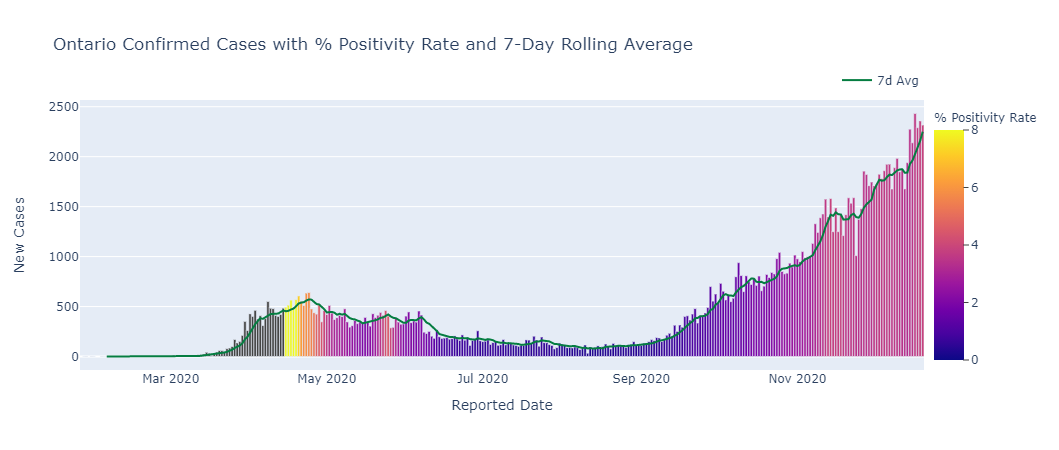

In [65]:
#hide_input

# report daily case load and % positivity

fig_conf = px.bar(df_testing,
              x='Reported Date',
              y='New Cases',
              color='7 Day Avg Percent Positivity', range_color=[0,8],
              title='Ontario Confirmed Cases with % Positivity Rate and 7-Day Rolling Average',
              labels={'7 Day Avg Percent Positivity': '% Positivity Rate'}
              )
fig_conf.update_layout(bargap=0)

fig_conf.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=1,
                                          ticks="outside",
                                          ticksuffix=""))

fig_conf.add_trace(go.Scatter(
    x=df_testing['Reported Date'],
    y=df_testing['New Cases 7 Day Average'],
    mode='lines',
    name='7d Avg',
    line=dict(color="#057D41", dash="solid")
    ))

fig_conf.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

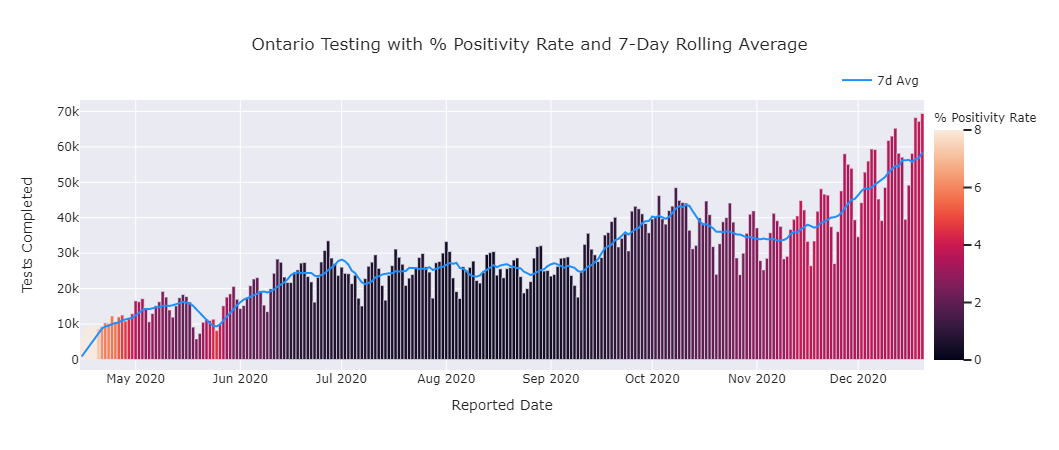

In [66]:
#hide_input

# report tests completed

# testing data does not exist prior to April 15, 2020
df_test = df_testing[(df_testing["Total tests completed in the last day"].notnull()) & (df_testing["Total tests completed in the last day"] != 0)]

fig_test = px.bar(df_test,
              x='Reported Date',
              y='Total tests completed in the last day',
              template='seaborn',
              color='7 Day Avg Percent Positivity', range_color=[0,8],
              title='Ontario Testing with % Positivity Rate and 7-Day Rolling Average',
              labels={'7 Day Avg Percent Positivity': '% Positivity Rate',
                      'Total tests completed in the last day': 'Tests Completed'},
 )           
fig_test.update_layout(bargap=0)

fig_test.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=1,
                                          ticks="outside",
                                          ticksuffix=""))

fig_test.add_trace(go.Scatter(
    x=df_test['Reported Date'],
    y=df_test['New Tests 7 Day Average'],
    mode='lines',
    name='7d Avg',
    line=dict(color="#1E90FF", dash="solid")
    ))

fig_test.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

In [67]:
#hide_input
display(HTML("<div style='text-Align: right; margin-right: 10%;'> <span style='text-align: right'> **Note that testing data is not available prior to April 15, 2020. </span> </div>"))